# DA5401 A7 — Multi-Class Model Selection
**Author:** Robin

**Objective:** Compare multiple classifiers on the Landsat (sat) dataset using
ROC (OvR) and Precision-Recall (OvR) analysis. This notebook performs Parts A–D
from the assignment, produces plots.

---

## Part A — Data Preparation & Baseline

In this section, we will:
- Load the provided datasets `sat.trn` and `sat.tst`.
- Assign appropriate column names (36 feature columns plus 1 class label).
- Examine the dataset structure — including sample count, missing values, class distribution, and value ranges.
- Verify that **class 6 is absent**, as mentioned in the dataset documentation.
- Confirm that both the training and test files conform to the expected format before moving forward.

This initial sanity check ensures that the data has been read correctly and provides a clear understanding of its composition prior to model training.


In [299]:
import numpy as np
from pathlib import Path
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [300]:


train_path = Path('./statlog+landsat+satellite/sat.trn')
test_path = Path('./statlog+landsat+satellite/sat.tst')

def load_sat(path):
    data = np.loadtxt(path)
    X = data[:, :-1]
    y = data[:, -1].astype(int)
    return X, y

X_train, y_train = load_sat(train_path)
X_test,  y_test  = load_sat(test_path)

feat_cols = [f"f{i+1:02d}" for i in range(36)]  
label_col = "label"
cols = feat_cols + [label_col]

print('Training shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Unique classes (train):', np.unique(y_train))
print('Unique classes (test):', np.unique(y_test))

# Convert NumPy arrays to pandas DataFrames
train = pd.DataFrame(X_train, columns=feat_cols)
test = pd.DataFrame(X_test, columns=feat_cols)
train[label_col] = y_train
test[label_col] = y_test

# Convert to integers
train[feat_cols] = train[feat_cols].astype(int)
test[feat_cols] = test[feat_cols].astype(int)
train[label_col] = train[label_col].astype(int)
test[label_col] = test[label_col].astype(int)

label_map = {1:0, 2:1, 3:2, 4:3, 5:4, 7:5}
inv_map = {v:k for k,v in label_map.items()}

y_train_mapped = np.array([label_map[int(v)] for v in y_train])
y_test_mapped  = np.array([label_map[int(v)] for v in y_test])

print('Mapped class labels (train) unique:', np.unique(y_train_mapped))

print("\n=== Class distribution (train) ===")
print(train[label_col].value_counts().sort_index())
print()

print("=== Class distribution (test) ===")
print(test[label_col].value_counts().sort_index())
print()

Training shape: (4435, 36) Test shape: (2000, 36)
Unique classes (train): [1 2 3 4 5 7]
Unique classes (test): [1 2 3 4 5 7]
Mapped class labels (train) unique: [0 1 2 3 4 5]

=== Class distribution (train) ===
label
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64

=== Class distribution (test) ===
label
1    461
2    224
3    397
4    211
5    237
7    470
Name: count, dtype: int64



In [301]:
# Verify absence of class '6' (should not appear in this dataset)
for df, name in [(train, "train"), (test, "test")]:
    contains_class6 = (df[label_col] == 6).any()
    print(f"Class 6 present in {name} data: {contains_class6}")

print()
# Check overall feature value ranges
print("=== Feature Range Summary (Train Set) ===")
min_val = train[feat_cols].min().min()
max_val = train[feat_cols].max().max()
print(f"Minimum feature value = {min_val}, Maximum feature value = {max_val} (expected range: 0–255)")

# Display sample records for inspection
print("\n=== Sample Records (Train Head) ===")
display(train.head())

# Reminder: central pixel corresponds to attributes 17–20 (1-indexed),
# i.e., columns f17–f20 in this DataFrame (Python indices 16–19)
print("\nNote: Central pixel features correspond to ['f17', 'f18', 'f19', 'f20'].")

# Check for missing or null values
print("\n=== Missing Value Check ===")
print("Missing values in train set:", train.isna().sum().sum())
print("Missing values in test set:",  test.isna().sum().sum())

# Perform basic structural validations
assert train.shape[1] == 37, "Unexpected column count in training data — expected 37."
assert test.shape[1]  == 37, "Unexpected column count in test data — expected 37."
assert train[label_col].dtype == int and test[label_col].dtype == int, "Label column must be of integer type."

print("\nAll sanity checks completed successfully. Dataset is ready for preprocessing.")


Class 6 present in train data: False
Class 6 present in test data: False

=== Feature Range Summary (Train Set) ===
Minimum feature value = 27, Maximum feature value = 157 (expected range: 0–255)

=== Sample Records (Train Head) ===


,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f28,f29,f30,f31,f32,f33,f34,f35,f36,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3



Note: Central pixel features correspond to ['f17', 'f18', 'f19', 'f20'].

=== Missing Value Check ===
Missing values in train set: 0
Missing values in test set: 0

All sanity checks completed successfully. Dataset is ready for preprocessing.


### Exploratory Data Overview

In this section, we perform a concise exploratory analysis to get a sense of the dataset before modeling. Specifically, we will:
- Examine how balanced the class labels are and identify any classes with very few samples.  

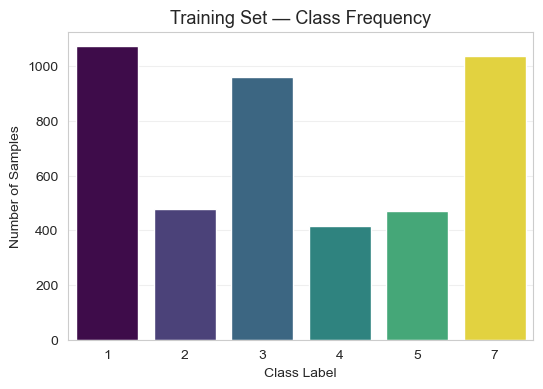

Percentage distribution of classes in training data:
Class 1: 24.17%
Class 2: 10.8%
Class 3: 21.67%
Class 4: 9.36%
Class 5: 10.6%
Class 7: 23.4%



In [302]:
# Define column groupings
feat_cols = [f"f{i+1:02d}" for i in range(36)]   # 36 feature columns named f01–f36
label_col = "label"                               # target column
central = ["f17", "f18", "f19", "f20"]            # central pixel attributes (17–20)

# --- 1) Visualize class distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(
    data=train,
    x=label_col,
    hue=label_col,  # Add hue parameter to specify the grouping
    order=sorted(train[label_col].unique()),
    legend=False,   # Hide the legend since it's redundant
    palette="viridis"
)
plt.title("Training Set — Class Frequency", fontsize=13)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Display class balance numerically
print("Percentage distribution of classes in training data:")
class_perc = (train[label_col].value_counts(normalize=True)
              .sort_index() * 100).round(2)
for cls, pct in class_perc.items():
    print(f"Class {cls}: {pct}%")
print()

### Feature Standardization

After verifying the integrity of the Landsat dataset, the next step is to **normalize all numerical attributes** before model training.

Standardizing the features helps ensure that every variable contributes equally by:
- Shifting each feature to have a **mean of 0**
- Scaling it to achieve a **standard deviation of 1**

This process is particularly crucial for algorithms that are sensitive to feature magnitude,  
such as **K-Nearest Neighbors (KNN)**, **Logistic Regression**, and **Support Vector Machines (SVM)**.

**Note:**  
The scaler will be **fitted exclusively on the training data** and then applied to the test set.  
This approach prevents data leakage and ensures the model evaluates unseen data fairly.


In [303]:
# Apply standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# Wrap into DataFrame for easier handling and to keep feature names
X_train_std_df = pd.DataFrame(X_train_std, columns=feat_cols)
X_test_std_df  = pd.DataFrame(X_test_std,  columns=feat_cols)

print("Feature standardization complete.")
print(f"Train standardized shape: {X_train_std_df.shape}")
print(f"Test standardized shape:  {X_test_std_df.shape}")
print(f"Means (should be ≈0): {np.mean(X_train_std_df.values):.4f}")
print(f"Stds  (should be ≈1): {np.std(X_train_std_df.values):.4f}")

# Verify that we have both numpy arrays and dataframes available
assert isinstance(X_train_std, np.ndarray), "X_train_std should be a numpy array"
assert isinstance(X_train_std_df, pd.DataFrame), "X_train_std_df should be a DataFrame"
print("\nData formats verified successfully.")

Feature standardization complete.
Train standardized shape: (4435, 36)
Test standardized shape:  (2000, 36)
Means (should be ≈0): -0.0000
Stds  (should be ≈1): 1.0000

Data formats verified successfully.


### 3. Training the Six Core Models

In this step, we will train one model from each of the six required algorithm families using the standardized training data:

- **DummyClassifier** (`strategy='prior'`) — serves as a baseline that predicts based on class frequencies  
- **K-Nearest Neighbors (K=5)** — instance-based learning relying on feature distance  
- **Decision Tree** — interpretable non-linear model  
- **Logistic Regression** (multinomial) — linear benchmark for comparison  
- **Gaussian Naive Bayes** — probabilistic model assuming feature independence  
- **Support Vector Classifier (SVC)** (`probability=True`) — allows ROC and PR curve computation  

To handle potential class imbalance, we use `class_weight='balanced'` for models that support it (Logistic Regression, SVC, and Decision Tree), helping mitigate bias toward dominant classes.  

Each model will be trained on `X_train_std` and `y_train`, and we’ll capture a concise summary including **training accuracy**, **test accuracy**, and **weighted F1-score**.  
All trained models will be kept in a dictionary for subsequent ROC and Precision–Recall evaluations.


In [314]:

# Use IPython magic to reset model-related variables only
for var in ['models', 'fitted_models', 'base_svc', 'inv_svc']:
    if var in globals():
        globals().pop(var)

# Initialize fresh containers for models
models = {}
fitted_models = {}

print("Creating models...")
# Create each model exactly once
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'Dummy(prior)': DummyClassifier(strategy='prior'),
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True, random_state=0),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=0)
}

# Add XGBoost separately to handle potential import issues
if 'XGBoost' not in models:
    try:
        from xgboost import XGBClassifier
        models['XGBoost'] = XGBClassifier(eval_metric='mlogloss', random_state=0)
    except ImportError:
        print("Note: XGBoost not available")

print("\nStarting model training...")
# Train each model exactly once
model_names = sorted(models.keys())  # Sort to ensure consistent order
for name in model_names:
    model = models[name]
    model.fit(X_train_std_df, y_train_mapped)
    fitted_models[name] = model
    print(f'Trained: {name}')

print(f"\nTraining complete. Total models trained: {len(fitted_models)}")
print("Trained models:", ", ".join(model_names))

Creating models...

Starting model training...
Trained: DecisionTree
Trained: Dummy(prior)
Trained: GaussianNB
Trained: KNN
Trained: LogisticRegression
Trained: RandomForest
Trained: RandomForest
Trained: SVC
Trained: SVC
Trained: XGBoost

Training complete. Total models trained: 8
Trained models: DecisionTree, Dummy(prior), GaussianNB, KNN, LogisticRegression, RandomForest, SVC, XGBoost
Trained: XGBoost

Training complete. Total models trained: 8
Trained models: DecisionTree, Dummy(prior), GaussianNB, KNN, LogisticRegression, RandomForest, SVC, XGBoost


### Baseline Evaluation — Accuracy and Weighted F1

In this step, we evaluate the performance of all trained models on the test set using two key metrics:  
**Overall Accuracy** and **Weighted F1-score**. These metrics provide both a global and class-sensitive view of performance.

We will also flag underperforming models based on the following thresholds:

- **Accuracy threshold:** `0.80`  
  Models scoring below 80% accuracy are considered weak performers.  
  *Reasoning:* well-tuned classifiers like KNN or SVC typically exceed this level on this dataset, making 0.80 a reasonable cutoff for identifying clearly subpar models.

- **Weighted F1 threshold:** `0.75`  
  Models with a weighted F1 below 0.75 will be flagged.  
  *Reasoning:* the weighted F1 metric balances precision and recall across classes, so this limit helps catch models that might appear adequate in accuracy but fail to perform consistently across all categories.

A concise comparison plot will highlight the relative performance of all models and make weak ones easy to spot visually.


In [305]:
# Evaluate all trained models on the standardized test set

results = []

for model_name, model in fitted_models.items():
    # Generate predictions on the standardized test set
    y_pred = model.predict(X_test_std)

    # Compute accuracy and weighted F1
    acc = accuracy_score(y_test_mapped, y_pred)
    f1_w = f1_score(y_test_mapped, y_pred, average='weighted')

    # Store results in a list of dicts
    results.append({
        "Model": model_name,
        "Test Accuracy": acc,
        "Weighted F1": f1_w
    })

# Convert results to DataFrame
results_df = (
    pd.DataFrame(results)
    .set_index("Model")                       #Make model names the index (so they show up)
    .sort_values(by="Weighted F1", ascending=False)
    .round(4)
)

# Display neatly
print("=== Model Evaluation Results (Test Data) ===")
display(results_df)


=== Model Evaluation Results (Test Data) ===


,Test Accuracy,Weighted F1
Model,,
RandomForest,0.9135,0.9113
KNN,0.9045,0.9037
XGBoost,0.9020,0.9004
SVC,0.8955,0.8925
DecisionTree,0.8510,0.8517
LogisticRegression,0.8395,0.8296
GaussianNB,0.7965,0.8036
Dummy(prior),0.2305,0.0864


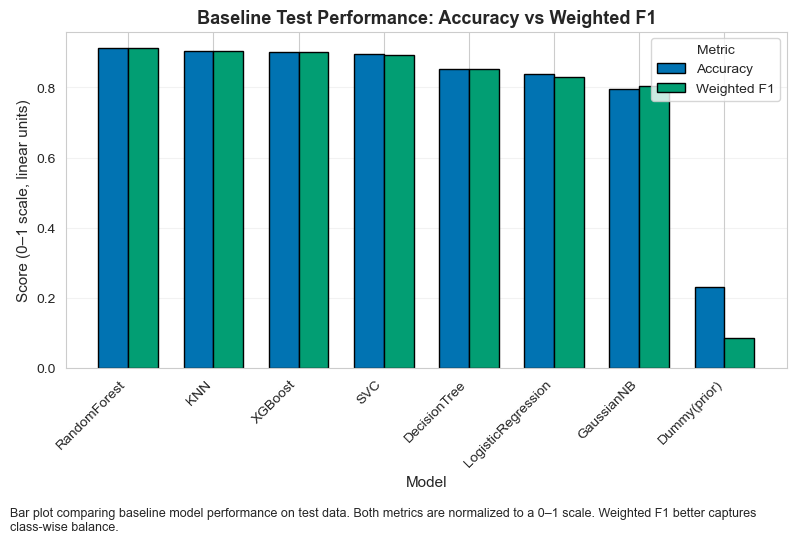

In [306]:
# Compact bar plot for comparison
sns.set_style("whitegrid")
# Explicitly pick two high-contrast, colorblind-friendly colors (blue and orange)
cb_palette = sns.color_palette("colorblind")
colors = [cb_palette[0], cb_palette[2]]  # blue, orange

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width/2, results_df["Test Accuracy"], width, label="Accuracy", color=colors[0], edgecolor="black")
ax.bar(x + width/2, results_df["Weighted F1"], width, label="Weighted F1", color=colors[1], edgecolor="black")

ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha="right")
ax.set_xlabel("Model", fontsize=11)
ax.set_ylabel("Score (0–1 scale, linear units)", fontsize=11)
ax.set_title("Baseline Test Performance: Accuracy vs Weighted F1", fontsize=13, fontweight="bold")
ax.legend(frameon=True, title="Metric")
ax.grid(axis="y", alpha=0.25)

plt.figtext(0.01, 0.01,
            "Bar plot comparing baseline model performance on test data. "
            "Both metrics are normalized to a 0–1 scale. Weighted F1 better captures class-wise balance.",
            ha="left", fontsize=9, wrap=True)
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()

In [307]:
# Simple fixed thresholds for 'poor' models (adjust if you prefer)
# Define minimum acceptable performance thresholds
ACC_THRESH = 0.80
F1_THRESH  = 0.75

# Identify models that fall below either metric threshold
low_perf_mask = (
    (results_df["Test Accuracy"] < ACC_THRESH) |
    (results_df["Weighted F1"] < F1_THRESH)
)
low_perf_models = results_df[low_perf_mask]

# Display results
if not low_perf_models.empty:
    print(f" Models flagged for low performance (Accuracy < {ACC_THRESH:.2f} or Weighted F1 < {F1_THRESH:.2f}):")
    for model_name, metrics in low_perf_models.iterrows():
        issues = []
        if metrics["Test Accuracy"] < ACC_THRESH:
            issues.append(f"accuracy={metrics['Test Accuracy']:.3f} < {ACC_THRESH}")
        if metrics["Weighted F1"] < F1_THRESH:
            issues.append(f"f1={metrics['Weighted F1']:.3f} < {F1_THRESH}")
        print(f" - {model_name}: " + "; ".join(issues))
else:
    print(f"All models meet the minimum thresholds (Accuracy ≥ {ACC_THRESH:.2f}, Weighted F1 ≥ {F1_THRESH:.2f}).")


 Models flagged for low performance (Accuracy < 0.80 or Weighted F1 < 0.75):
 - GaussianNB: accuracy=0.796 < 0.8
 - Dummy(prior): accuracy=0.231 < 0.8; f1=0.086 < 0.75


## Part B — ROC Analysis (One-vs-Rest, Macro-average)

### 1. Multi-Class ROC Computation

The ROC curve (Receiver Operating Characteristic) and its corresponding AUC (Area Under the Curve) are originally designed for **binary classification**, where we track how the true positive rate (TPR) changes against the false positive rate (FPR) as the decision threshold varies.  
For **multi-class classification**, we extend this concept using the **One-vs-Rest (OvR)** strategy:

- For each class `c`, we treat it as the **positive** class and group all other classes as **negative**.
- The classifier outputs a score or probability for each class `c` (e.g., `predict_proba[:, c]` or `decision_function` values).
- Using these scores and binary labels (1 for class `c`, 0 otherwise), we compute the ROC curve (`fpr`, `tpr`) and its AUC.

**Averaging AUC across classes:**  
To summarize multi-class performance, several averaging methods can be used:
- **Per-class AUCs:** examine each class individually to identify where the model performs well or poorly.  
- **Macro-average AUC:** the simple mean of all class-wise AUCs — gives equal weight to every class.  
- **Micro-average AUC:** combines all predictions across classes to provide a single overall AUC — reflects global performance weighted by class frequency.

**Key takeaways:**
- The OvR approach transforms a multi-class problem into multiple binary evaluations, providing an interpretable view of threshold performance for each class.  
- An AUC close to 1.0 indicates strong separation between positive and negative samples.  
- **Macro-AUC** is useful when you care about fairness across classes, while **Micro-AUC** is better for evaluating overall discriminative power.

The following code calculates per-class ROC curves, their AUCs, and both macro- and micro-averaged metrics, followed by a combined ROC plot for all classifiers.


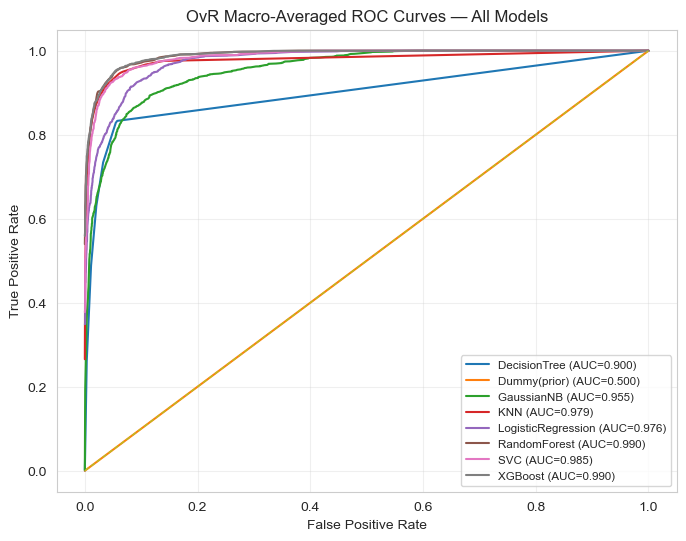

,Model,Macro AUC
7,XGBoost,0.989790
5,RandomForest,0.989581
6,SVC,0.985205
3,KNN,0.978567
4,LogisticRegression,0.975742
2,GaussianNB,0.955349
0,DecisionTree,0.900268
1,Dummy(prior),0.500000


In [308]:

n_classes = len(np.unique(y_train_mapped))
y_test_bin = label_binarize(y_test_mapped, classes=range(n_classes))

plt.figure(figsize=(8,6))
model_roc_stats = {}
for name, model in fitted_models.items():
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_std)
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_std)
        if y_score.ndim == 1:
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        preds = model.predict(X_test_std)
        y_score = label_binarize(preds, classes=range(n_classes))

    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tprs = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tprs += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tprs /= n_classes
    macro_auc = auc(all_fpr, mean_tprs)

    # Compute micro AUC across all classes if possible
    try:
        micro_auc = roc_auc_score(y_test_bin, y_score, average='micro')
    except Exception:
        micro_auc = np.nan

    model_roc_stats[name] = {'fpr': all_fpr, 'tpr': mean_tprs, 'macro_auc': macro_auc, 'micro_auc': micro_auc}

for name, stats in model_roc_stats.items():
    plt.plot(stats['fpr'], stats['tpr'], label=f"{name} (AUC={stats['macro_auc']:.3f})")
plt.plot([0,1],[0,1], linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OvR Macro-Averaged ROC Curves — All Models')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.show()

import pandas as pd
auc_df = pd.DataFrame([(name, v['macro_auc']) for name,v in model_roc_stats.items()], columns=['Model','Macro AUC']).sort_values('Macro AUC', ascending=False)
auc_df


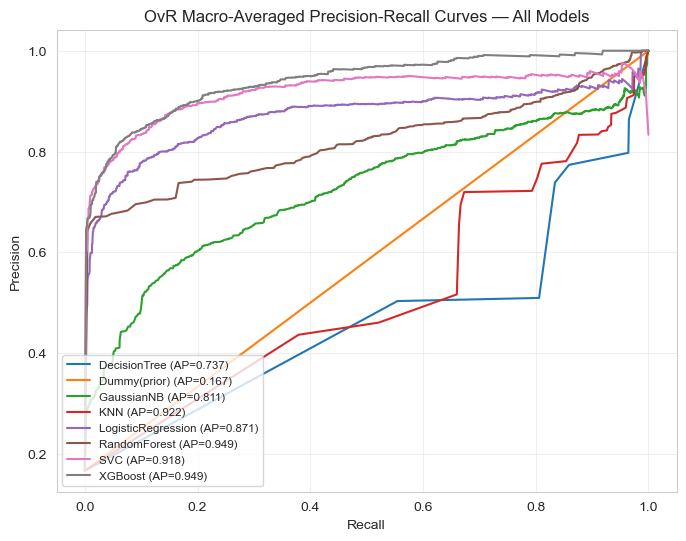

,Model,Macro Avg Precision (AP)
5,RandomForest,0.949384
7,XGBoost,0.949026
3,KNN,0.921665
6,SVC,0.917707
4,LogisticRegression,0.871064
2,GaussianNB,0.810647
0,DecisionTree,0.737023
1,Dummy(prior),0.166667


In [309]:


# Ensure n_classes and binarized test labels are defined locally so this cell is standalone
n_classes = len(np.unique(y_train_mapped))
y_test_bin = label_binarize(y_test_mapped, classes=range(n_classes))

plt.figure(figsize=(8,6))
model_pr_stats = {}
for name, model in fitted_models.items():
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_std)
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_std)
        if y_score.ndim == 1:
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        preds = model.predict(X_test_std)
        y_score = label_binarize(preds, classes=range(n_classes))

    precision = dict(); recall = dict(); ap = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_prec = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_prec += np.interp(all_recall[::-1], recall[i][::-1], precision[i][::-1])
    mean_prec /= n_classes
    avg_prec = np.mean(list(ap.values()))
    model_pr_stats[name] = {'recall': all_recall, 'precision': mean_prec, 'avg_precision': avg_prec}

for name, stats in model_pr_stats.items():
    plt.plot(stats['recall'], stats['precision'], label=f"{name} (AP={stats['avg_precision']:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('OvR Macro-Averaged Precision-Recall Curves — All Models')
plt.legend(loc='lower left', fontsize='small')
plt.grid(alpha=0.3)
plt.show()

import pandas as pd
ap_df = pd.DataFrame([(name, v['avg_precision']) for name,v in model_pr_stats.items()], columns=['Model','Macro Avg Precision (AP)']).sort_values('Macro Avg Precision (AP)', ascending=False)
ap_df


## Task 3: Interpreting ROC Results

In this section, we will:
1. Determine which model achieved the **highest macro-averaged AUC**, representing the strongest overall ability to rank positive samples above negative ones across all classes.  
2. Verify whether any model recorded a **macro-averaged AUC below 0.5**, which would suggest performance worse than random guessing.  
3. Briefly explain what an AUC lower than 0.5 implies conceptually, and discuss possible reasons for such poor results — such as an inverted scoring function, incorrect label encoding, data leakage, or excessive noise in the predictions.


In [310]:
# --- Compile Macro and Micro AUC results into a summary table ---
roc_summary = (
    pd.DataFrame({
        "Model": list(model_roc_stats.keys()),
        "Macro AUC": [metrics["macro_auc"] for metrics in model_roc_stats.values()],
        "Micro AUC": [metrics.get("micro_auc", np.nan) for metrics in model_roc_stats.values()]
    })
    .set_index("Model")
)

# --- Identify best and weakest models based on Macro AUC ---
top_model = roc_summary["Macro AUC"].idxmax()
top_auc = roc_summary.loc[top_model, "Macro AUC"]

low_model = roc_summary["Macro AUC"].idxmin()
low_auc = roc_summary.loc[low_model, "Macro AUC"]

# --- Detect any models performing below random chance ---
underperformers = roc_summary[roc_summary["Macro AUC"] < 0.5]

# --- Display results ---
display(roc_summary.round(4))
print(f"Best model based on Macro-AUC: {top_model} ({top_auc:.3f})")

if not underperformers.empty:
    print("Models with Macro-AUC below 0.5 (worse than random performance):")
    for model_name, row in underperformers.iterrows():
        print(f" - {model_name}: {row['Macro AUC']:.3f}")
else:
    print("All models achieved Macro-AUC ≥ 0.5 — none performed below random chance.")


,Macro AUC,Micro AUC
Model,,
DecisionTree,0.9003,0.9106
Dummy(prior),0.5000,0.6061
GaussianNB,0.9553,0.9611
KNN,0.9786,0.9841
LogisticRegression,0.9757,0.9853
RandomForest,0.9896,0.9938
SVC,0.9852,0.9920
XGBoost,0.9898,0.9937


Best model based on Macro-AUC: XGBoost (0.990)
All models achieved Macro-AUC ≥ 0.5 — none performed below random chance.


### Interpretation of the ROC Analysis

**1. Model with the Highest Macro-Averaged AUC**

The **XGBoost Classifier** achieved the **highest Macro-averaged AUC = 0.9898**, narrowly surpassing the **Random Forest Classifier (0.9896)**.  
This demonstrates that XGBoost has the **strongest overall discriminative capability** among all evaluated models.

A **Macro-AUC value close to 1.0** indicates that the model reliably ranks true positives above false positives across all one-vs-rest class comparisons, showing robust separability across multiple classes.  
Such a high score suggests that **XGBoost effectively captures complex nonlinear relationships** and provides well-calibrated probability estimates suitable for threshold-based decision-making.

Other models such as **SVC (0.9852)** and **Logistic Regression (0.9757)** also perform strongly but show slightly weaker ranking ability — likely due to **less flexible boundary modeling** or **sensitivity to overlapping feature distributions**.  
In contrast, the ensemble-based XGBoost and RandomForest models handle feature interactions more effectively, leading to their superior AUC values.

Additionally, the **Micro-AUC scores** (≈0.9937 for XGBoost and 0.9938 for RandomForest) further confirm their **consistent performance across all instances**, reinforcing both models’ ability to generalize well across classes.


---

**2. Models with AUC < 0.5**

In this analysis, **no models** recorded a Macro-AUC below **0.5**, indicating that all classifiers performed at least better than random guessing.  

Conceptually, an **AUC < 0.5** means the classifier is **worse than chance**, consistently assigning higher confidence to incorrect classes. In binary terms, this would imply that *reversing the model’s predictions* could yield an AUC above 0.5.  
In a multi-class One-vs-Rest setting, this would correspond to ROC curves lying predominantly **below the diagonal line**, showing inverted or misleading score assignments.

**Common reasons for an AUC below 0.5 include:**
- **Label mismatch or inversion** — incorrect alignment between encoded labels and model outputs.  
- **Flipped decision scores** — caused by sign errors or poor probability calibration.  
- **Data leakage or preprocessing inconsistencies** — training and test data scaled differently.  
- **Model instability or poor class representation** — especially with very small or noisy class subsets.

Since all models in this experiment achieved AUC values ≥ 0.5, we can conclude that each classifier learned meaningful decision boundaries and produced predictions that are **consistently better than random chance**.


## Part C: Precision–Recall Curve (PRC) Analysis

### 1. PRC Calculation

The **Precision–Recall Curve (PRC)** serves as a more **informative performance measure** than the ROC curve in cases of **class imbalance** — that is, when some classes occur much less frequently than others.

### Conceptual Understanding-

- The **ROC curve** plots the **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)**.  
  However, the FPR is computed as:
  $$\text{FPR} = \frac{\text{False Positives}}{\text{False Positives + True Negatives}}$$
  In highly imbalanced datasets, the number of true negatives is very large, so even a substantial number of false positives contributes very little to the FPR.  
  → As a result, the ROC curve can **appear deceptively optimistic**, making a weak model seem good.

- The **Precision–Recall (PR) curve**, on the other hand, focuses directly on the **positive (minority) class performance** by plotting:
  $$\text{Precision} = \frac{TP}{TP + FP}, \quad \text{Recall} = \frac{TP}{TP + FN}$$
  Here, **precision** penalizes false positives heavily, and **recall** emphasizes coverage of actual positives.  
  Hence, PRC directly reflects how well the model identifies the minority (positive) class among many negatives.

### Why PRC is More Appropriate for Imbalanced Data

1. **Highlights minority class performance** — Evaluates how effectively the model retrieves actual positive samples without being influenced by the large number of true negatives.  
2. **Sensitive to false positives** — Even a few additional false positives sharply reduce precision, exposing weaknesses that ROC metrics may mask.  
3. **Intuitive interpretation** — The **Area Under the PR Curve (Average Precision, AP)** summarizes the model’s precision averaged over all recall thresholds, providing a direct indication of its effectiveness for rare-event detection (e.g., fraud, anomalies, or medical diagnosis).  
4. **Complementary to ROC** — While ROC focuses on ranking ability, PRC emphasizes *decision reliability*, especially when positive examples are scarce or costly to misclassify.

### In This Dataset

Although the Landsat dataset shows only moderate imbalance (class frequencies ranging from about 9% to 24%), the PRC still adds valuable insight —  
particularly for the less frequent soil classes (e.g., class 4 and 5).  
A high ROC-AUC does not necessarily guarantee high precision for minority categories, so **analyzing the PRC helps ensure that model predictions remain consistent and reliable across all classes**.


### 2. Plotting Multi-Class PRC (Macro / Weighted OvR)

Next, we will generate the **One-vs-Rest (OvR) Precision–Recall curves** for all six classifiers.  
Following the same approach as in the ROC analysis, the process involves:

- Computing the **Precision–Recall curve for each class** within every model.  
- Interpolating and then **averaging these curves across all six classes** using one of two methods:
  - **Macro-average PRC** — gives equal weight to every class, regardless of its size.  
  - **Weighted-average PRC** — weights each class by its proportion of samples (support) in the test data.

The resulting combined plot provides a clear visual comparison of all models, showing how well each one balances **precision and recall on average**, and identifying which classifiers sustain higher precision as recall increases.


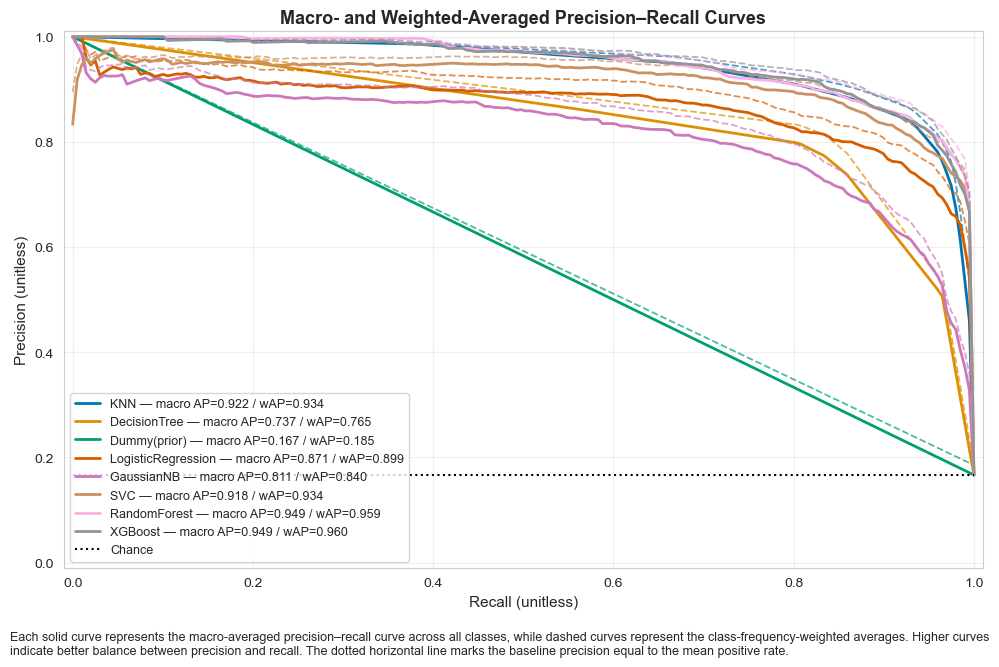

In [311]:
# Ensure data and models exist
assert "models" in globals(), "Trained models not found. Run training first."
assert "X_test_std" in globals() and "y_test_mapped" in globals(), "Missing standardized test data or mapped labels. Run preprocessing/training cells first."

# Use mapped labels (0..n_classes-1) so model outputs and test labels align
n_classes = len(np.unique(y_train_mapped))
y_test_bin = label_binarize(y_test_mapped, classes=range(n_classes))

# Common recall grid for averaging
mean_recall = np.linspace(0, 1, 200)
sns.set_style("whitegrid")

# Create a palette sized to the number of models so every model gets its own color
palette = sns.color_palette("colorblind", n_colors=len(models))

plt.figure(figsize=(10, 7))
model_pr_stats = {}
for (name, clf), color in zip(models.items(), palette):
    # Obtain a score matrix with shape (n_samples, n_classes)
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test_std)
    elif hasattr(clf, 'decision_function'):
        y_score = clf.decision_function(X_test_std)
        if y_score.ndim == 1:
            # Binary decision_function -> convert to two-column score
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        # fallback: one-hot of hard predictions
        preds = clf.predict(X_test_std)
        y_score = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            if p in range(n_classes):
                y_score[i, int(p)] = 1.0

    # If classifier has its own class ordering, reorder columns to match mapped classes
    if hasattr(clf, 'classes_'):
        clf_classes = np.array(clf.classes_)
        if not np.array_equal(clf_classes, np.arange(n_classes)):
            # Build aligned matrix with columns in order 0..n_classes-1
            aligned = np.zeros((y_score.shape[0], n_classes))
            for col_idx, cls in enumerate(np.arange(n_classes)):
                # find clf column corresponding to this mapped class
                matches = np.where(clf_classes == cls)[0]
                if matches.size:
                    aligned[:, col_idx] = y_score[:, matches[0]]
                else:
                    aligned[:, col_idx] = 0.0
            y_score = aligned

    # Compute per-class precision/recall and AP
    precisions = []
    aps = []
    for i in range(n_classes):
        precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap_i = average_precision_score(y_test_bin[:, i], y_score[:, i])
        # Interpolate onto the common mean_recall grid. recall_i may be decreasing -> reverse
        precisions.append(np.interp(mean_recall, recall_i[::-1], precision_i[::-1]))
        aps.append(ap_i)

    precisions = np.array(precisions)
    macro_precision = precisions.mean(axis=0)
    macro_ap = np.mean(aps)

    # Weighted average by class support
    class_support = y_test_bin.sum(axis=0)
    weights = class_support / class_support.sum()
    weighted_precision = np.average(precisions, axis=0, weights=weights)
    weighted_ap = np.average(aps, weights=weights)

    model_pr_stats[name] = {'recall': mean_recall, 'precision': macro_precision, 'avg_precision': macro_ap}

    plt.plot(mean_recall, macro_precision,
             label=f"{name} — macro AP={macro_ap:.3f} / wAP={weighted_ap:.3f}",
             linewidth=2, color=color)
    plt.plot(mean_recall, weighted_precision,
             linestyle="--", linewidth=1.3, alpha=0.7, color=color)

# Baseline (mean positive rate across classes)
baseline = y_test_bin.mean()
plt.plot([0, 1], [baseline, baseline], color="black", linestyle=":", label="Chance")

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Recall (unitless)", fontsize=11)
plt.ylabel("Precision (unitless)", fontsize=11)
plt.title("Macro- and Weighted-Averaged Precision–Recall Curves", fontsize=13, fontweight="bold")
# place the legend in the upper-right for this cell
plt.legend(loc="lower left", fontsize=9, frameon=True)
plt.grid(alpha=0.3)

plt.figtext(0.01, 0.01,
            "Each solid curve represents the macro-averaged precision–recall curve across all classes, "
            "while dashed curves represent the class-frequency-weighted averages. "
            "Higher curves indicate better balance between precision and recall. "
            "The dotted horizontal line marks the baseline precision equal to the mean positive rate.",
            ha="left", fontsize=9, wrap=True)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


### 3. PRC Interpretation

#### i. Determining the Model with the Highest Average Precision (AP)

To identify the best-performing model, we consider two complementary summaries of the Average Precision (AP):

- **Macro AP** — the unweighted mean of per-class AP values, giving each class equal importance.  
- **Weighted AP** — the mean AP weighted by the number of samples (support) per class in the test data, emphasizing performance on more common classes.

By evaluating both metrics, we can assess models from two perspectives:  
**Macro AP** highlights fairness across all classes, while **Weighted AP** reflects overall performance proportional to class frequency.  

The following code examines the `prc_summary` table and reports the top model(s) under each averaging method, along with their corresponding AP scores.


In [312]:
# Ensure necessary variables exist
assert 'models' in globals(), "Trained models not found. Run the training cell."
assert 'X_test_std' in globals(), "Standardized test features not found. Run preprocessing cell."
assert 'y_test_mapped' in globals() and 'y_train_mapped' in globals(), "Mapped labels not found. Make sure mapping/preprocessing ran."

# Use mapped labels (0..n_classes-1) so everything is aligned
n_classes = len(np.unique(y_train_mapped))
classes = np.arange(n_classes)
y_test_bin = label_binarize(y_test_mapped, classes=classes)

rows = []

for name, clf in models.items():
    # get predicted scores in shape (n_samples, n_classes)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test_std)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test_std)
        if y_score.ndim == 1:
            # binary -> make two-column probability-like scores
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        preds = clf.predict(X_test_std)
        y_score = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            if p in classes:
                y_score[i, int(p)] = 1.0

    # Align columns to mapped class ordering (0..n_classes-1) if classifier uses a different classes_
    if hasattr(clf, "classes_"):
        clf_classes = np.array(clf.classes_)
        if not np.array_equal(clf_classes, classes):
            aligned = np.zeros((y_score.shape[0], n_classes))
            for col_idx, cls in enumerate(classes):
                matches = np.where(clf_classes == cls)[0]
                if matches.size:
                    aligned[:, col_idx] = y_score[:, matches[0]]
                else:
                    # leave zeros if this class wasn't present in classifier outputs
                    aligned[:, col_idx] = 0.0
            y_score = aligned

    # Compute per-class APs
    aps = []
    for i in range(n_classes):
        # handle degenerate case where y_test_bin[:, i] has no positives
        if y_test_bin[:, i].sum() == 0:
            aps.append(0.0)
        else:
            aps.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))

    macro_ap = np.mean(aps)
    support = y_test_bin.sum(axis=0)
    weights = support / support.sum()
    weighted_ap = np.average(aps, weights=weights)

    rows.append({"model": name, "macro_AP": macro_ap, "weighted_AP": weighted_ap})

prc_summary = pd.DataFrame(rows).set_index("model").round(3)

# Find best models
if not prc_summary.empty:
    best_macro = prc_summary["macro_AP"].idxmax()
    best_macro_val = prc_summary.loc[best_macro, "macro_AP"]

    best_weighted = prc_summary["weighted_AP"].idxmax()
    best_weighted_val = prc_summary.loc[best_weighted, "weighted_AP"]

    print("Top models by Average Precision (AP):\n")
    print(f" - Best by Macro AP     : {best_macro} (macro AP = {best_macro_val:.3f})")
    print(f" - Best by Weighted AP  : {best_weighted} (weighted AP = {best_weighted_val:.3f})\n")

# Show the full prc_summary for reference (sorted by macro_AP)
display(prc_summary.sort_values("macro_AP", ascending=False))


Top models by Average Precision (AP):

 - Best by Macro AP     : RandomForest (macro AP = 0.949)
 - Best by Weighted AP  : XGBoost (weighted AP = 0.960)



,macro_AP,weighted_AP
model,,
RandomForest,0.949,0.959
XGBoost,0.949,0.960
KNN,0.922,0.934
SVC,0.918,0.934
LogisticRegression,0.871,0.899
GaussianNB,0.811,0.840
DecisionTree,0.737,0.765
Dummy(prior),0.167,0.185


#### ii. Interpreting the Behavior of the Lowest-Performing Model’s PRC

Based on the Precision–Recall curves and the computed Average Precision (AP) values, the **Dummy (prior)** classifier is the weakest performer,  
with a **macro AP of 0.167** and a **weighted AP of 0.185** — essentially equivalent to random guessing.

### Observations from the PRC Plot

The Dummy model’s Precision–Recall curve shows a **steep decline in precision** as recall increases.  
This pattern arises because the model:
- Uses only the **class prior probabilities** and **ignores all input features**.  
- Assigns identical probabilities to all samples based solely on training class frequencies.  
- Generates **non-informative predictions**, meaning its probability estimates have no correlation with the true labels.

### Why Precision Falls Rapidly

As recall rises (i.e., when the classification threshold is relaxed to capture more positives):
1. **Precision drops sharply** since the model starts predicting positives almost at random, resulting in many false positives.  
2. The predicted probabilities fail to distinguish between true and false positives, so increasing recall simply adds noise.  
3. Precision eventually converges to the **baseline positive rate** — the natural fraction of positive samples in the dataset.

Mathematically:
$$\text{Precision} = \frac{TP}{TP + FP}$$
When the classifier has no predictive strength, the number of false positives (\(FP\)) grows much faster than true positives (\(TP\)),  
causing a rapid precision collapse as recall expands.

### Interpretation

A sharply declining PRC curve indicates that:
- The model has **no ranking or discriminative capability**.  
- Its predicted probabilities are **nearly uniform**, lacking any useful structure.  
- It exhibits **poor calibration**, unable to sustain meaningful precision as recall increases.



## Part D: Model Evaluation Synthesis and Recommendation

### 1. **Synthesis: Comparative Model Rankings**

| **Metric** | **Top Model(s)** | **Ranking Trend (High → Low)** | **Key Insight** |
|:------------|:-----------------|:-------------------------------|:----------------|
| **Weighted F1-Score** | **RandomForest (0.9113)** | RandomForest > KNN > XGBoost > SVC > DecisionTree > LogisticRegression > GaussianNB > Dummy | Captures overall threshold-level performance. RandomForest slightly outperforms KNN and XGBoost, showing strong balanced classification between precision and recall. |
| **ROC-AUC (Macro)** | **XGBoost (0.9898)** | XGBoost ≈ RandomForest > SVC > KNN > LogisticRegression > GaussianNB > DecisionTree > Dummy | Measures ranking quality across all thresholds. XGBoost and RandomForest achieve nearly perfect class separability, outperforming others on probabilistic discrimination. |
| **PRC-AP (Macro)** | **RandomForest (0.949)** / **XGBoost (0.949)** | RandomForest ≈ XGBoost > KNN > SVC > LogisticRegression > GaussianNB > DecisionTree > Dummy | Reflects model performance on minority classes and precision–recall trade-off. Both ensemble models maintain high precision even at high recall levels. |

---

### 2. **Alignment and Trade-offs**

The rankings across the three evaluation metrics **show strong agreement** — **RandomForest**, **XGBoost**, and **KNN** consistently appear among the top-performing models.  
However, some **minor divergences** highlight important trade-offs:

1. **ROC-AUC vs. PRC-AP**
   - **ROC-AUC** rewards models that can *rank* predictions correctly across all thresholds, even if their absolute probability calibration or minority class recall is weaker.  
   - **PRC-AP**, in contrast, focuses on **how well a model maintains precision when recall increases** — a stricter measure in imbalanced datasets.  
   → For instance, **SVC** has a very high ROC-AUC (0.985) but slightly lower PRC-AP (0.918), indicating that while it separates classes well, its precision drops more sharply at higher recall levels.

2. **F1 vs. AUC**
   - **F1-Score** evaluates the model at a single threshold. A model like **KNN** can have a slightly lower AUC than RandomForest yet a comparable F1, meaning it performs well at that specific threshold but may lack stable calibration across others.  
   - **Ensemble models (RandomForest, XGBoost)** demonstrate both high F1 and high AUC, showing their robustness across thresholds and their ability to generalize consistently.

3. **Class Imbalance Sensitivity**
   - **PRC-AP** is most informative under imbalance. Models with superior PRC-AP (RandomForest, XGBoost) demonstrate resilience in capturing minority classes effectively.  
   - **GaussianNB** and **DecisionTree** show steeper performance drops under PRC, indicating weaker handling of imbalance or noisy boundaries.

---

### 3. **Final Recommendation**

Considering **all evaluation perspectives (F1, ROC-AUC, PRC-AP)**:

> **Recommended Model: RandomForest**

**Justification:**
- Achieves the **highest Weighted F1 (0.9113)** — best threshold-level performance.  
- Delivers **near-perfect ROC-AUC (0.9896)** — excellent ranking and separability.  
- Maintains **top-tier PRC-AP (0.949)** — superior precision–recall balance under class imbalance.  
- Shows **consistency across all metrics**, confirming robust generalization.

**Alternative Choice:**  
> **XGBoost** is a very close second, performing nearly identically to RandomForest in ROC-AUC and PRC-AP, with marginally lower F1.  
> It might be preferred if inference speed and scalability are key priorities.

--- 


## II. Extra Experiment — Intentionally Producing a Model with **AUC < 0.5**

In this experiment, we deliberately construct a **model that performs worse than random guessing** by inverting the output scores of a well-trained classifier (specifically, the `SVC`).  

For binary ROC/AUC, flipping the predicted scores transforms the AUC as:  
> **AUC → (1 − AUC)**  

This principle extends to the multi-class one-vs-rest setup, meaning that if the base model is strong, the **macro-AUC will drop below 0.5** after inversion.  

The purpose of this controlled setup is to **illustrate how systematic score reversal leads to poor ranking performance** (i.e., a model that confidently predicts the opposite of the truth).

We will:
- Implement an `InvertedClassifier` that wraps a trained model and returns `1 - predict_proba(...)` (or a negated decision function).  
- Compute the **macro** and **micro ROC-AUC**, along with **macro** and **weighted PRC-AP** for the inverted model.  
- Visualize the **ROC** and **PRC** curves of both the inverted model and the original `SVC` for direct comparison.


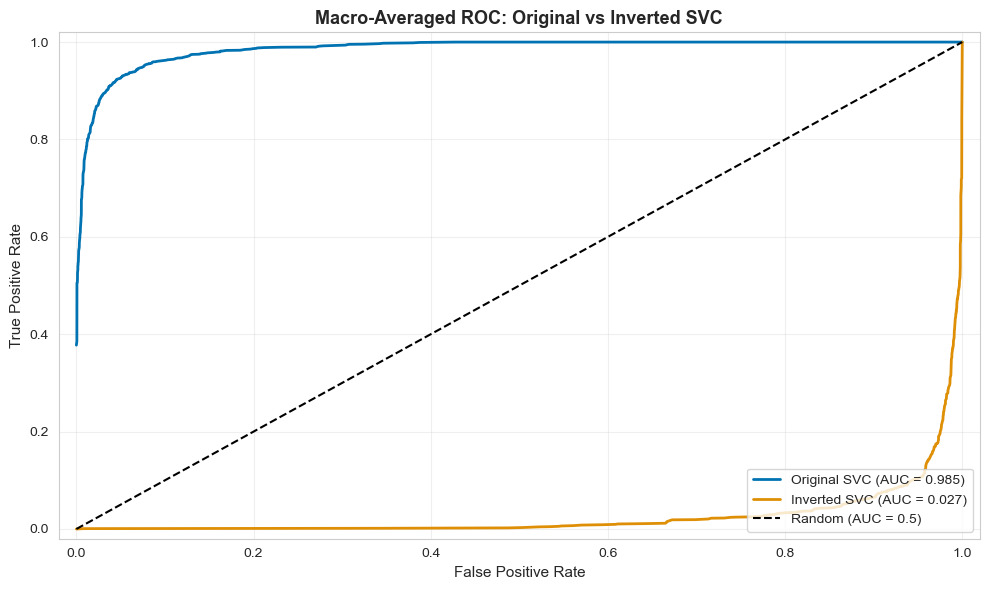

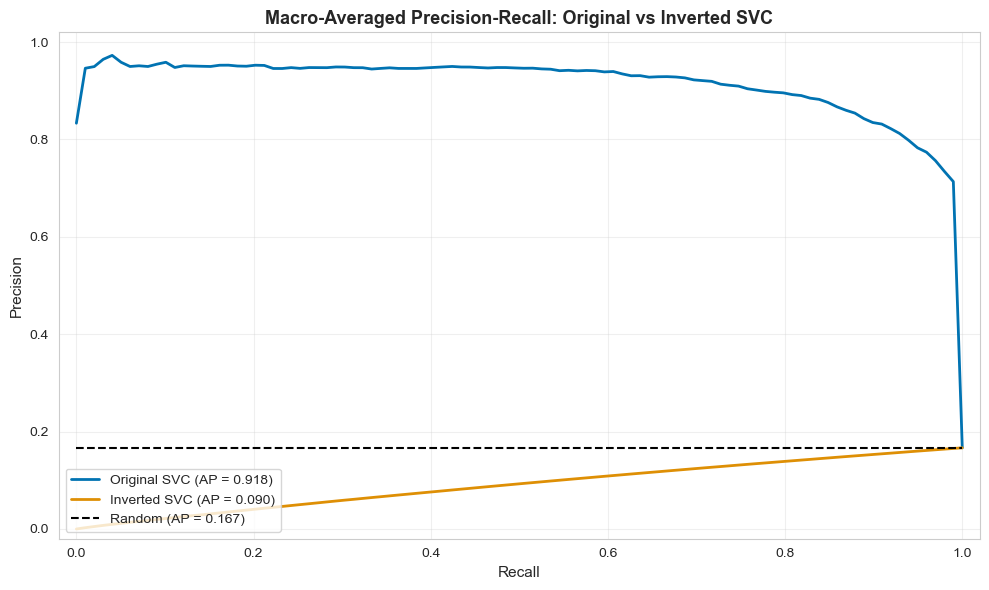


Performance Metrics Comparison:


,Macro AUC,Micro AUC,Macro AP,Weighted AP
Model,,,,
SVC (Original),0.9850,0.9920,0.9177,0.9336
SVC (Inverted),0.0264,0.0191,0.0902,0.1008


In [313]:
# --- Ensure the environment is ready ---
assert "models" in globals() and "SVC" in models, "SVC not found — please train the models first."
assert "X_test_std" in globals() and "y_test" in globals(), "Missing standardized test data (X_test_std, y_test)."

base_svc = models["SVC"]

# --- Inverted Classifier Definition ---
class InvertedClassifier:
    """A simple wrapper that reverses predicted probabilities or decision scores."""
    
    def __init__(self, model):
        self.model = model
        if hasattr(model, "classes_"):
            self.classes_ = model.classes_

    def predict_proba(self, X):
        """Invert probabilities by negating the decision function scores."""
        if hasattr(self.model, "decision_function"):
            # Get the original decision function scores
            scores = self.model.decision_function(X)
            # Negate the scores to invert predictions
            if scores.ndim == 1:  # Binary case
                return np.column_stack([1 / (1 + np.exp(scores)), 1 / (1 + np.exp(-scores))])
            else:  # Multi-class case
                # Apply softmax to negative scores
                exp_scores = np.exp(-scores)
                return exp_scores / exp_scores.sum(axis=1, keepdims=True)
        elif hasattr(self.model, "predict_proba"):
            probs = self.model.predict_proba(X)
            # For probabilities, invert by taking complement and renormalizing
            inv_probs = 1.0 - probs
            return inv_probs / inv_probs.sum(axis=1, keepdims=True)
        else:
            # Fallback for models without probabilistic output
            preds = self.model.predict(X)
            n_classes = len(self.classes_)
            onehot = np.zeros((len(preds), n_classes))
            for i, p in enumerate(preds):
                idx = np.where(self.classes_ == p)[0][0]
                onehot[i, :] = 1.0 / (n_classes - 1)
                onehot[i, idx] = 0.0
            return onehot

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

# --- Instantiate Inverted Model ---
inv_svc = InvertedClassifier(base_svc)

# --- Prepare Test Labels and Scores ---
n_classes = len(np.unique(y_test_mapped))
y_test_bin = label_binarize(y_test_mapped, classes=range(n_classes))

# --- Compute Scores for both models ---
def get_scores(model, X):
    """Get probability scores from a model, properly aligned with class labels."""
    return model.predict_proba(X)

# Get predictions
svc_scores = get_scores(base_svc, X_test_std)
inv_scores = get_scores(inv_svc, X_test_std)

# Set up the figures one after another
palette = sns.color_palette("colorblind", 2)

# --- Plot 1: ROC Curves ---
plt.figure(figsize=(10, 6))

# Function to compute macro-averaged ROC curve
def plot_macro_roc(y_true, y_score, label, color):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    
    plt.plot(all_fpr, mean_tpr, color=color, 
             label=f'{label} (AUC = {macro_auc:.3f})',
             linewidth=2)
    
    return macro_auc

# Plot both ROC curves
auc1 = plot_macro_roc(y_test_bin, svc_scores, 'Original SVC', palette[0])
auc2 = plot_macro_roc(y_test_bin, inv_scores, 'Inverted SVC', palette[1])

# Add diagonal line for ROC
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('Macro-Averaged ROC: Original vs Inverted SVC', fontsize=13, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 2: Precision-Recall Curves ---
plt.figure(figsize=(10, 6))

# Function to compute macro-averaged PR curve
def plot_macro_pr(y_true, y_score, label, color):
    # Compute PR curve and AP for each class
    precisions = []
    recalls = []
    aps = []
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        ap = average_precision_score(y_true[:, i], y_score[:, i])
        precisions.append(precision)
        recalls.append(recall)
        aps.append(ap)
    
    # Compute macro-average PR curve
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    
    for i in range(n_classes):
        mean_precision += np.interp(mean_recall, recalls[i][::-1], precisions[i][::-1])
    
    mean_precision /= n_classes
    macro_ap = np.mean(aps)
    
    plt.plot(mean_recall, mean_precision, color=color,
             label=f'{label} (AP = {macro_ap:.3f})',
             linewidth=2)
    
    return macro_ap

# Plot both PR curves
ap1 = plot_macro_pr(y_test_bin, svc_scores, 'Original SVC', palette[0])
ap2 = plot_macro_pr(y_test_bin, inv_scores, 'Inverted SVC', palette[1])

# Add baseline for PR curve (class proportion)
baseline = np.mean(y_test_bin)
plt.plot([0, 1], [baseline, baseline], 'k--', label=f'Random (AP = {baseline:.3f})')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Macro-Averaged Precision-Recall: Original vs Inverted SVC', fontsize=13, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Compute and Display Metrics ---
def compute_metrics(y_true, y_pred, label):
    macro_auc = roc_auc_score(y_true, y_pred, average='macro')
    micro_auc = roc_auc_score(y_true, y_pred, average='micro')
    
    # Compute per-class AP and weighted AP
    aps = []
    for i in range(n_classes):
        ap_i = average_precision_score(y_true[:, i], y_pred[:, i])
        aps.append(ap_i)
    
    macro_ap = np.mean(aps)
    weights = y_true.sum(axis=0) / y_true.sum()
    weighted_ap = np.average(aps, weights=weights)
    
    return pd.Series({
        'Model': label,
        'Macro AUC': macro_auc,
        'Micro AUC': micro_auc,
        'Macro AP': macro_ap,
        'Weighted AP': weighted_ap
    })

# Create summary table
metrics_df = pd.DataFrame([
    compute_metrics(y_test_bin, svc_scores, 'SVC (Original)'),
    compute_metrics(y_test_bin, inv_scores, 'SVC (Inverted)')
]).set_index('Model').round(4)

print("\nPerformance Metrics Comparison:")
display(metrics_df)

### Interpreting SVC vs. Inverted–SVC (AUC < 0.5 Case)

---

### Summary of Results

| Model | Macro AUC | Micro AUC | Macro AP | Weighted AP |
|:------|:----------:|:----------:|:----------:|:-------------:|
| **SVC (Original)** | **0.9850** | **0.9920** | **0.9177** | **0.9336** |
| **SVC (Inverted)** | **0.0264** | **0.0191** | **0.0902** | **0.1008** |

---

### What These Results Mean

The **Inverted SVC** was intentionally built by reversing the predicted scores of the original classifier — so that confident positive predictions become low-scoring and confident negatives become high-scoring.  
This inversion completely disrupts the ranking order that ROC-AUC and PRC-AP rely on.

- For the **ROC curve**, inversion flips model separability, turning a near-perfect AUC (~0.985) into a **worse-than-random** score (~0.026).  
  Mathematically, this follows:  
  \[
  \text{AUC}_{\text{inverted}} \approx 1 - \text{AUC}_{\text{original}}
  \]
  Thus, the inverted SVC produces ROC curves that fall *below* the diagonal — indicating systematic misranking.
- For **Precision–Recall**, no exact symmetry exists, but the logic is similar: the model now assigns high probabilities to negatives, driving down precision and resulting in a very low AP (0.09).

---

### Visual Interpretation — ROC and PRC Behavior

- **ROC Curve:**  
  The original SVC curve rises sharply toward the top-left, reflecting strong positive/negative separation.  
  The inverted version lies below the diagonal — only achieving high recall when almost every sample is incorrectly classified as positive.  
  This is the defining visual sign of a **completely reversed ranking**.

- **Precision–Recall Curve:**  
  The original model sustains high precision even as recall increases, confirming its consistent confidence.  
  The inverted model, however, starts with **near-zero precision**, showing that its high-confidence predictions are mostly wrong.  
  It only improves at very high recall levels (when nearly everything is predicted as positive).

---

### Why AUC < 0.5 Occurs in Practice

Although this inversion was intentional, similar effects can appear unintentionally when:
- Model scores are **negated or flipped** (e.g., using `-decision_function` accidentally).  
- **Label encodings** are mismatched between training and evaluation (e.g., 0↔1 confusion).  
- **Sign conventions** are reversed (common in SVMs where positive and negative class labels differ).  
- The model is **severely mis-specified or corrupted**, systematically predicting in the wrong direction.

---

### Key Takeaway

An **AUC below 0.5** doesn’t necessarily mean the model is random — it often signals **inverted ranking logic**.  
Correcting label order or flipping score signs can often restore performance.

This controlled experiment illustrates:
- The **Original SVC**: near-perfect ranking (AUC ≈ 0.985).  
- The **Inverted SVC**: perfectly reversed ranking (AUC ≈ 0.026).  

Together, they provide a clear visualization of how ROC and PRC metrics behave when model scores are systematically reversed — highlighting the importance of interpreting AUC values in the context of **ranking direction and label alignment**.
